In [1]:
import torch, torchvision
import torch.nn as nn
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

In [2]:
class NIN(nn.Module):
    def __init__(self, num_classes=10):
        super(NIN, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(3, 192, kernel_size=5, stride=1, padding=2), nn.ReLU(inplace=True),
                                   nn.Conv2d(192, 160, kernel_size=1, stride=1, padding=0), nn.ReLU(inplace=True),
                                   nn.Conv2d(160, 96, kernel_size=1, stride=1, padding=0), nn.ReLU(inplace=True))
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.dropout1 = nn.Dropout2d()
        
        self.conv2 = nn.Sequential(nn.Conv2d(96, 192, kernel_size=5, stride=1, padding=2), nn.ReLU(inplace=True),
                                   nn.Conv2d(192, 192, kernel_size=1, stride=1, padding=0), nn.ReLU(inplace=True),
                                   nn.Conv2d(192, 192, kernel_size=1, stride=1, padding=0), nn.ReLU(inplace=True))
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.dropout2 = nn.Dropout2d()
        
        self.conv3 = nn.Sequential(nn.Conv2d(192, 192, kernel_size=3, stride=1, padding=1), nn.ReLU(inplace=True),
                                   nn.Conv2d(192, 192, kernel_size=1, stride=1, padding=0), nn.ReLU(inplace=True),
                                   nn.Conv2d(192, 10, kernel_size=1, stride=1, padding=0), nn.ReLU(inplace=True))
        
        self.pool3 = nn.AvgPool2d(kernel_size=8, stride=1)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        #x = self.dropout1(x)
        
        x = self.conv2(x)
        x = self.pool2(x)
        #x = self.dropout2(x)
        
        x = self.conv3(x)
        heatmap = x
        
        x = self.pool3(x)
        
        x = torch.flatten(x, 1)
        x = self.softmax(x)
        return heatmap, x

In [3]:
num_classes = 10
weight_file = './best.pt'

NIN = NIN(num_classes=num_classes)
NIN.load_state_dict(torch.load(weight_file))

<All keys matched successfully>

In [4]:
batch_size = 11

test_transform = transforms.Compose([
    transforms.Pad(padding=4), transforms.Resize(40), transforms.CenterCrop(35),
    transforms.ToTensor(), transforms.Normalize(mean=[0.4921, 0.4828, 0.4474], std=[0.1950, 0.1922, 0.1940])])

test_dataset = torchvision.datasets.CIFAR10('../Dataset/cifar10/', train=False, download=True, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified


In [5]:
NIN.eval()
with torch.no_grad():
    for i, (X, y) in enumerate(test_loader):
        heatmaps, predicts = NIN(X)
        predicts = torch.argmax(predicts, 1)
        break

In [6]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

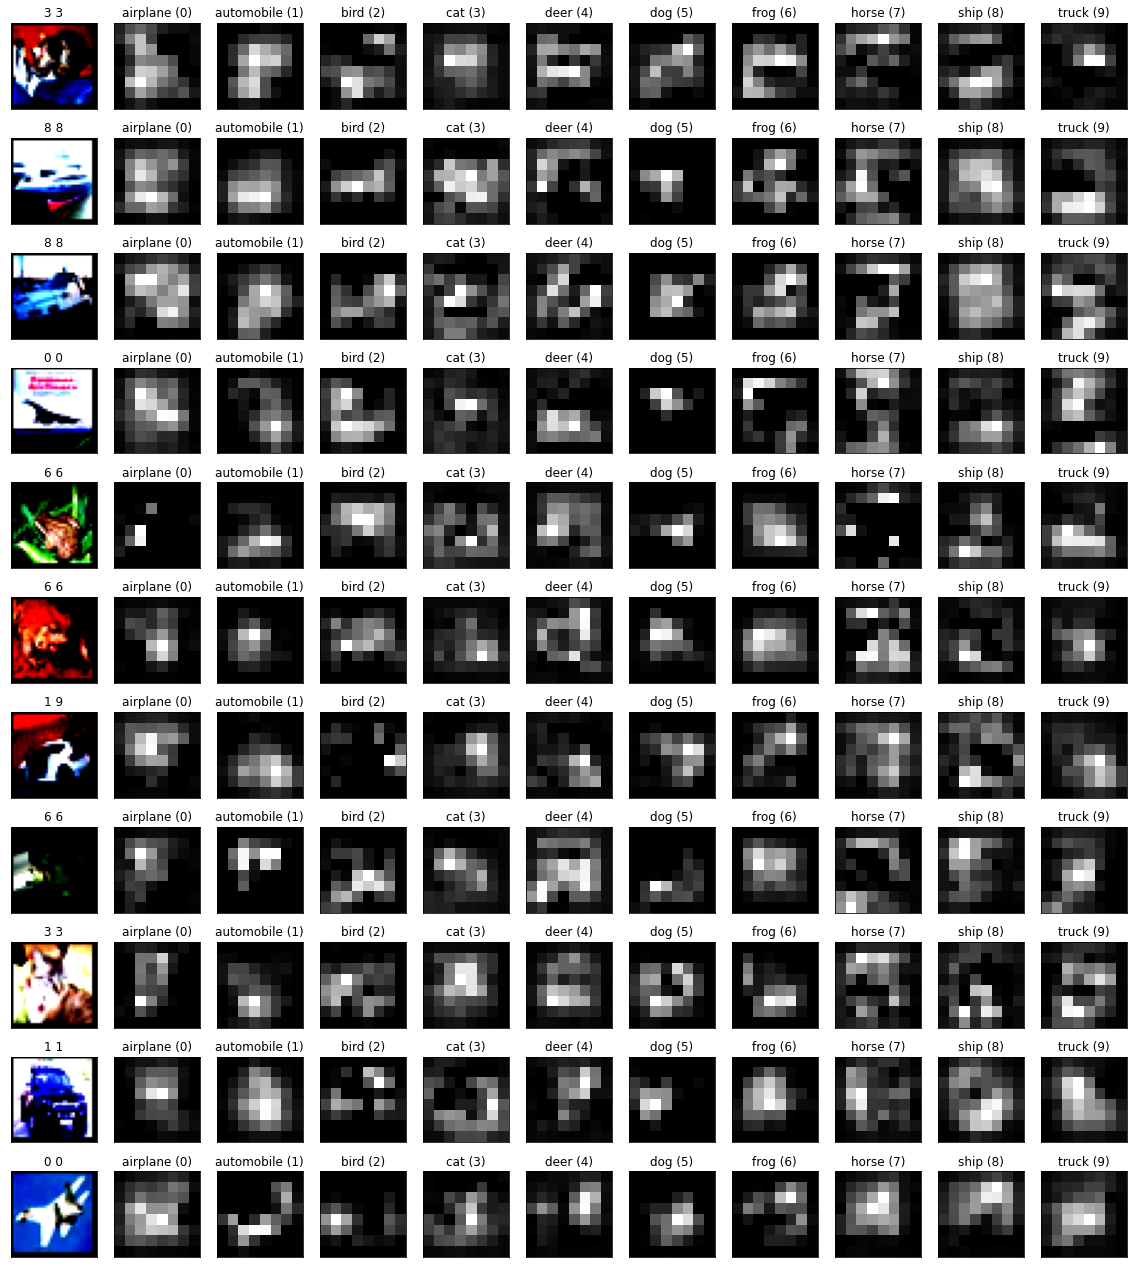

In [7]:
# Feature Maps Visualization
plt.figure(figsize=(20, 25))
plt.axis('off')

for i in range(batch_size):
    plt.subplot(batch_size+1, num_classes+1, batch_size*i + 1)
    img = plt.imshow(X[i].permute(1, 2, 0).numpy())
    img.axes.get_xaxis().set_visible(False)
    img.axes.get_yaxis().set_visible(False)
    plt.gca().set_title(str(y[i].item()) + ' ' + str(predicts[i].item()))
    for j in range(num_classes):
        plt.subplot(batch_size+1, num_classes+1, batch_size*i + j + 2)
        img = plt.imshow(heatmaps[i][j].numpy(), cmap=plt.cm.gray)
        img.axes.get_xaxis().set_visible(False)
        img.axes.get_yaxis().set_visible(False)
        plt.gca().set_title(labels[j] + ' ({})'.format(j))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

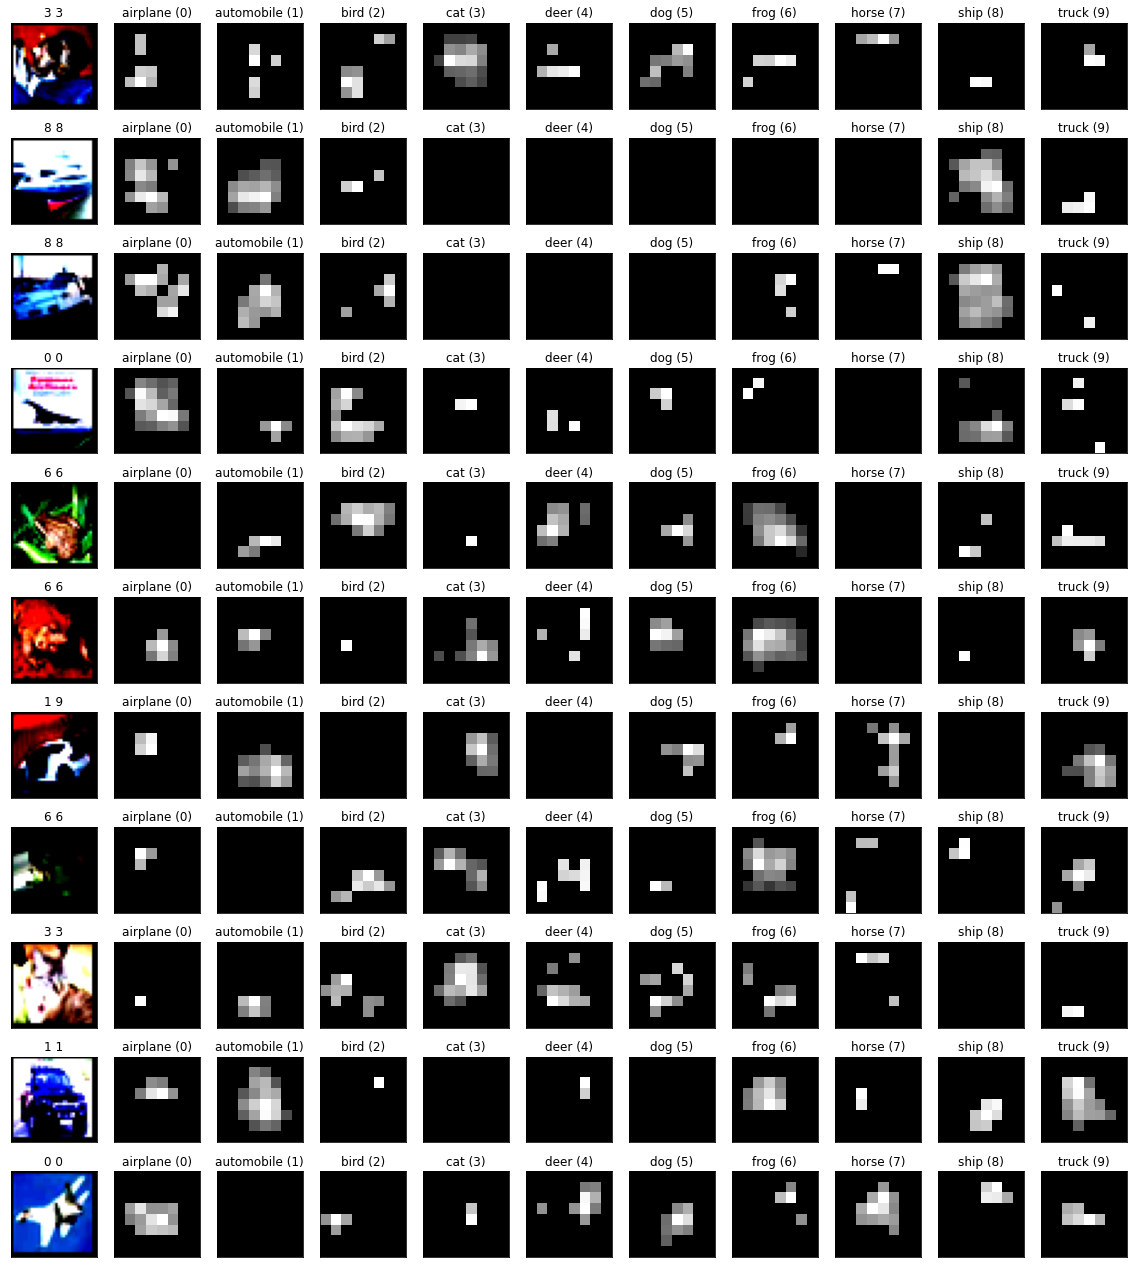

In [8]:
# Feature Maps Visualization of only top 10% activations following the paper
plt.figure(figsize=(20, 25))
plt.axis('off')

for i in range(batch_size):
    plt.subplot(batch_size+1, num_classes+1, batch_size*i + 1)
    img = plt.imshow(X[i].permute(1, 2, 0).numpy())
    img.axes.get_xaxis().set_visible(False)
    img.axes.get_yaxis().set_visible(False)
    plt.gca().set_title(str(y[i].item()) + ' ' + str(predicts[i].item()))
    threshold = torch.flatten(heatmaps[i])
    threshold = int(sorted(threshold, reverse=True)[threshold.size(0)//10].item())
    for j in range(num_classes):
        plt.subplot(batch_size+1, num_classes+1, batch_size*i + j + 2)
        heatmap = heatmaps[i][j]
        heatmap[heatmap < threshold] = 0
        img = plt.imshow(heatmap.numpy(), cmap=plt.cm.gray)
        img.axes.get_xaxis().set_visible(False)
        img.axes.get_yaxis().set_visible(False)
        plt.gca().set_title(labels[j] + ' ({})'.format(j))